In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 



import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import copy
import math
from decimal import *
import tensorflow as tf
import cv2
import scipy
import scipy.spatial.distance as sp
import pathlib
import imageio
import json
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['riverdataset', 'jsonfiles', 'riverdataset2', 'spamemail']


**SPAM EMAIL DATASET**

In [2]:
missing_values = ["n/a", "na", "--"]
data = pd.read_csv('../input/spamemail/spam.csv', encoding = "ISO-8859-1")
data = data.dropna(axis=1)
data = data.replace({'v1': {'ham': 0, 'spam': 1}}).dropna(axis=1)
data.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
def preprocess_string(str_arg):
    cleaned_str=re.sub('[^a-z\s]+',' ',str_arg,flags=re.IGNORECASE)
    cleaned_str=re.sub('(\s+)',' ',cleaned_str)
    cleaned_str=cleaned_str.lower()
    
    return cleaned_str

In [4]:
data['text'] = data['v2'].apply(preprocess_string)
data.head()

,v1,v2,text
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final ...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...


In [5]:
def prepare_count(df):
  word_dict = {0: {}, 1: {}}
  sample_count = {0: 0, 1: 0}
  word_count = {0: 0 , 1: 0}
  for _, r in df.iterrows():
    cls = r['v1']
    sample_count[cls] += 1
    for w in r['text'].split():
      word_count[cls] += 1
      word_dict[cls][w] = word_dict[cls].get(w, 0) + 1
  
  return word_dict, sample_count, word_count

In [6]:
train_data, test_data = train_test_split(data, test_size=0.3, shuffle=True)
print(train_data.size, test_data.size)

11700 5016


In [7]:
word_dict,sample_count,word_count = prepare_count(train_data)
spam_dict = word_dict[1]
ham_dict = word_dict[0]
spam_count = sample_count[1]
ham_count = sample_count[0]
spam_wc = word_count[1]
ham_wc = word_count[0]
# print(ham_wc,spam_wc)
print(len(ham_dict))

5486


In [8]:
test_data.head()

,v1,v2,text
4552,0,Sun ah... Thk mayb can if dun have anythin on....,sun ah thk mayb can if dun have anythin on thk...
1203,0,Thanks for understanding. I've been trying to ...,thanks for understanding i ve been trying to t...
4716,0,"K will do, addie &amp; I are doing some art so...",k will do addie amp i are doing some art so i ...
1256,0,"Not yet chikku..going to room nw, i'm in bus..",not yet chikku going to room nw i m in bus
3717,0,Cool. Do you like swimming? I have a pool and ...,cool do you like swimming i have a pool and ja...


In [9]:
def get_probability(df,cls):
    probabilities = []
    class_prob = Decimal(sample_count[cls])/Decimal((spam_count+ham_count))
    new_dict = copy.deepcopy(spam_dict)
    new_dict.update(ham_dict)
    numer = class_prob
#     numer = np.log(spam_prob)
    denom = 1
    for _, r in df.iterrows():
        #one particular email
        cls = r['v1']
        #numerator calculation
        for w in r['text'].split():
            if w in word_dict[cls].keys():
                prob = Decimal((word_dict[cls][w]+1))/Decimal((word_count[cls]+1+len(word_dict[cls])))
                numer *= Decimal(prob)
#                 numer += np.log(prob)
            else:
                prob = Decimal(1)/Decimal(word_count[cls]+1+len(word_dict[cls]))
                numer *= Decimal(prob)
#                 numer += np.log(prob)
        #denominator calculation
#         for w in r['text'].split():
#             c1 = 1
#             c2 = 1
#             if w in spam_dict.keys():
#                 c1 += spam_dict[w]
#             if w in ham_dict.keys():
#                 c2 += ham_dict[w]
# #             prob = (c1 + c2) / (spam_count + ham_count + 1 + len(new_dict))
#             prob1 = Decimal((c1/(spam_wc+1+len(new_dict))))*Decimal((spam_count/(spam_count+ham_count)))
#             prob2 = Decimal((c2/(ham_wc+1+len(new_dict))))*Decimal((ham_count/(spam_count+ham_count)))
#             prob = Decimal(prob1)+Decimal(prob2)
# #             print(prob)
#             denom *= Decimal(prob)
# #             denom += np.log(prob)
# #         sample_probability = Decimal(numer)/Decimal((denom))
        sample_probability = Decimal(numer)
#         sample_probability = numer - denom
#         probabilities.append(np.exp(sample_probability))
        probabilities.append(sample_probability)
    return probabilities
    
    
    

In [10]:
probabilities_spam = get_probability(test_data,1)
probabilities_ham = get_probability(test_data,0)
# print(probabilities)

In [11]:
Y_pred = []
length = len(probabilities_spam)
for s in range(length):
    if probabilities_ham[s] > probabilities_spam[s]:
        Y_pred.append(0)
    else:
        Y_pred.append(1)
    


Y_actual = test_data['v1']

acc = accuracy_score(Y_pred, Y_actual)
print(acc, 'is the accuracy')

0.8630382775119617 is the accuracy


**RIVER DATASET(PIXEL BY PIXEL)**

In [12]:
data = []
paths = pathlib.Path('../input/riverdataset/images').glob('*/*.jpg')
for x in paths:
    val = cv2.imread(str(x),0)
    data.append(val)
print(paths)    
data_arr = np.asarray(data)
print(data_arr.shape)
print(os.listdir("../input/jsonfiles"))

<generator object Path.glob at 0x7f28aa5dd6d0>
(4, 512, 512)
['send-archive']


In [13]:
#df = pd.read_json("/input/river-ds/send-archive/river.json", lines = True)
with open("../input/jsonfiles/send-archive/river.json") as df_river:
    data = json.load(df_river)
df_river = pd.DataFrame(data)
df_river = df_river.values
#dataframe

In [14]:
Dict_river = {} 
for i in range (256):
    Dict_river[i] = 0
#Dict
for k in range (4):
    for i in range (76):
        m = df_river[i][0]
        n = df_river[i][1]
        Dict_river[data_arr[k][m][n]] = Dict_river[data_arr[k][m][n]] + 1
Dict_river

{0: 288,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 0,
 51: 0,
 52: 0,
 53: 0,
 54: 0,
 55: 0,
 56: 0,
 57: 0,
 58: 0,
 59: 0,
 60: 0,
 61: 0,
 62: 0,
 63: 0,
 64: 0,
 65: 0,
 66: 0,
 67: 0,
 68: 0,
 69: 0,
 70: 0,
 71: 0,
 72: 0,
 73: 0,
 74: 0,
 75: 0,
 76: 0,
 77: 0,
 78: 0,
 79: 0,
 80: 0,
 81: 0,
 82: 0,
 83: 0,
 84: 0,
 85: 0,
 86: 0,
 87: 0,
 88: 0,
 89: 0,
 90: 0,
 91: 0,
 92: 0,
 93: 0,
 94: 0,
 95: 0,
 96: 0,
 97: 0,
 98: 0,
 99: 0,
 100: 0,
 101: 0,
 102: 0,
 103: 0,
 104: 0,
 105: 0,
 106: 0,
 107: 0,
 108: 0,
 109: 0,
 110: 0,
 111: 0,
 112: 0,
 113: 0,
 114: 0,
 115: 0,
 116: 0,
 117: 0,
 118: 0,
 119: 0,
 120: 0,
 121: 0,
 122: 0,
 

In [15]:
with open("../input/jsonfiles/send-archive/not-river.json") as df_not_river:
    data = json.load(df_not_river)
df_not_river = pd.DataFrame(data)
df_not_river = df_not_river.values
Dict_not_river = {} 
for i in range (256):
    Dict_not_river[i] = 0
#Dict
for k in range (4):
    for i in range(197):
        m = df_not_river[i][0]
        n = df_not_river[i][1]
        Dict_not_river[data_arr[k][m][n]] = Dict_not_river[data_arr[k][m][n]] + 1
           
Dict_not_river

{0: 757,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 3,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 0,
 51: 0,
 52: 0,
 53: 0,
 54: 0,
 55: 0,
 56: 0,
 57: 0,
 58: 0,
 59: 0,
 60: 0,
 61: 0,
 62: 0,
 63: 0,
 64: 0,
 65: 0,
 66: 0,
 67: 0,
 68: 0,
 69: 0,
 70: 0,
 71: 0,
 72: 0,
 73: 0,
 74: 0,
 75: 0,
 76: 0,
 77: 0,
 78: 0,
 79: 0,
 80: 0,
 81: 0,
 82: 0,
 83: 0,
 84: 0,
 85: 0,
 86: 0,
 87: 0,
 88: 0,
 89: 0,
 90: 0,
 91: 0,
 92: 0,
 93: 0,
 94: 0,
 95: 0,
 96: 0,
 97: 0,
 98: 0,
 99: 0,
 100: 0,
 101: 0,
 102: 0,
 103: 0,
 104: 0,
 105: 0,
 106: 0,
 107: 0,
 108: 0,
 109: 0,
 110: 0,
 111: 0,
 112: 0,
 113: 0,
 114: 0,
 115: 0,
 116: 0,
 117: 0,
 118: 0,
 119: 0,
 120: 0,
 121: 0,
 122: 0,
 

In [16]:
def get_probability_river(val1,val2,val3,val4):
#     class_prob = Decimal(len(df_river))/Decimal(len(df_not_river)+len(df_river))
    class_prob = Decimal(1/2)
    numer = class_prob
    denom = 1
    count = 0
    for value in Dict_river.values():
        if value!=0:
            count = count+1
    prob1 = Decimal((Dict_river[val1]+1))/Decimal(76*4+1+count)
    prob2 = Decimal((Dict_river[val2]+1))/Decimal(76*4+1+count)
    prob3 = Decimal((Dict_river[val3]+1))/Decimal(76*4+1+count)
    prob4 = Decimal((Dict_river[val4]+1))/Decimal(76*4+1+count)
    numer *= Decimal(prob1)*Decimal(prob2)*Decimal(prob3)*Decimal(prob4)
        #denominator calculation
#     prob = Decimal(Dict_river[val]+2+Dict_not_river[val])/Decimal(76*4+197*4+255+2)
#     denom *= Decimal(prob)
#     sample_probability = Decimal(numer)/Decimal((denom))
    sample_probability = Decimal(numer)
    return sample_probability  
    

In [17]:
def get_probability_notriver(val1,val2,val3,val4):
    class_prob = Decimal(1/2)
#     class_prob = Decimal(len(df_not_river))/Decimal(len(df_not_river)+len(df_river))
    numer = class_prob
    denom = 1
    count = 0
    for value in Dict_not_river.values():
        if value!=0:
            count = count+1
    prob1 = Decimal((Dict_not_river[val1]+1))/Decimal(197*4+1+count)
    prob2 = Decimal((Dict_not_river[val2]+1))/Decimal(197*4+1+count)
    prob3 = Decimal((Dict_not_river[val3]+1))/Decimal(197*4+1+count)
    prob4 = Decimal((Dict_not_river[val4]+1))/Decimal(197*4+1+count)
    numer *= Decimal(prob1)*Decimal(prob2)*Decimal(prob3)*Decimal(prob4)
        #denominator calculation
#     prob = Decimal(Dict_river[val]+2+Dict_not_river[val])/Decimal(76*4+197*4+255+2)
#     denom *= Decimal(prob)
#     sample_probability = Decimal(numer)/Decimal((denom))
    sample_probability = Decimal(numer)
    return sample_probability 

(4, 262144)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


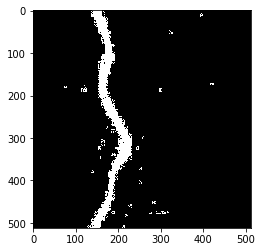

In [18]:
data = []
output = []
paths = pathlib.Path('../input/riverdataset/images').glob('*/*.jpg')
for x in paths:
    val = cv2.imread(str(x),0)
    val = val.flatten()
    data.append(val)
data = np.asarray(data)
print(data.shape)
for i in range(262144):
    if get_probability_river(data[0][i],data[1][i],data[2][i],data[3][i]) > get_probability_notriver(data[0][i],data[1][i],data[2][i],data[3][i]):
        output.append(255)
#         print("yay")
    else:
#         print("nay")
        output.append(0)
        
output = np.reshape(output, [512, 512])
print(output)
plt.imshow(output,cmap="gray")

            

**RIVER DATASET(Using Bayes Decision Rule)**

In [19]:
import glob
# river_dataset_path = '../input/riverdataset2/images'
# raw_image_files = pathlib.Path('../input/riverdataset/images').glob('*/*.jpg')
# raw_image_files = glob.glob(f'{river_dataset_path}/PDCV*.jpeg')
# raw_image_files = glob.glob(f'{river_dataset_path}/UDCV*.jpeg')
data = []
paths = pathlib.Path('../input/riverdataset2/images').glob('*/*.jpg')
for x in paths:
    val = cv2.imread(str(x),0)
    data.append(val)
print(paths)    
images = np.asarray(data)
print(data_arr.shape)
# paths = pathlib.Path('../input/riverdataset2/images').glob('*/*.jpg')
masked_image = ''
paths2 = pathlib.Path('../input/riverdataset/images').glob('*/*.jpg')
for x in paths2:
    masked_image = cv2.imread(str(x),0)
    break

<generator object Path.glob at 0x7f28ab18c620>
(4, 512, 512)


In [20]:
n_river_pts = 50
n_not_river_pts = 100
print(masked_image)
# this needs to be thresholded
_, masked_image = cv2.threshold(masked_image, 127, 255, cv2.THRESH_BINARY)

# prepare samples of points having coordinates of river and not-river
river_coords = np.argwhere(masked_image == 255)
not_river_coords = np.argwhere(masked_image == 0)
assert(len(river_coords) + len(not_river_coords) == 512*512)

river_pts = river_coords[
    np.random.choice(len(river_coords), n_river_pts)
]
not_river_pts = not_river_coords[
    np.random.choice(len(not_river_coords), n_not_river_pts)
]

river_samples = np.array([images[:, x, y] for x, y in river_pts]).T
not_river_samples = np.array([images[:, x, y] for x, y in not_river_pts]).T

print(river_samples.shape, not_river_samples.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(4, 50) (4, 100)


In [21]:
# calculating means for both classes
mean_river = river_samples.mean(axis=1).reshape((4,1))
mean_not_river = not_river_samples.mean(axis=1).reshape((4, 1))
cov_river = np.cov(river_samples)
cov_not_river = np.cov(not_river_samples)

# calculating inverses and determinants : pre-computation
cov_river_inv = np.linalg.pinv(cov_river)
cov_not_river_inv = np.linalg.pinv(cov_not_river)
det_cov_river = np.linalg.det(cov_river)
det_cov_not_river = np.linalg.det(cov_not_river)

In [22]:
import itertools 

def predict(p_prior_river, p_prior_not_river):
  result = np.zeros((512, 512))
  xs = list(range(512))
  for x, y in itertools.product(xs, xs):
    cur_sample = images[:, x, y].reshape((4, 1))
    diff = cur_sample - mean_river
    river_cls = np.linalg.multi_dot([diff.T, cov_river_inv, diff]).item()
    
    diff = cur_sample - mean_not_river
    not_river_cls = np.linalg.multi_dot([diff.T, cov_not_river_inv, diff]).item()
    
    p_river = -0.5 * np.sqrt(det_cov_river) / np.exp(river_cls)
    p_not_river = -0.5 * np.sqrt(det_cov_not_river) / np.exp(not_river_cls)
    
    result[x, y] = 0 if p_river*p_prior_river >= p_not_river*p_prior_not_river else 255
  return result

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  


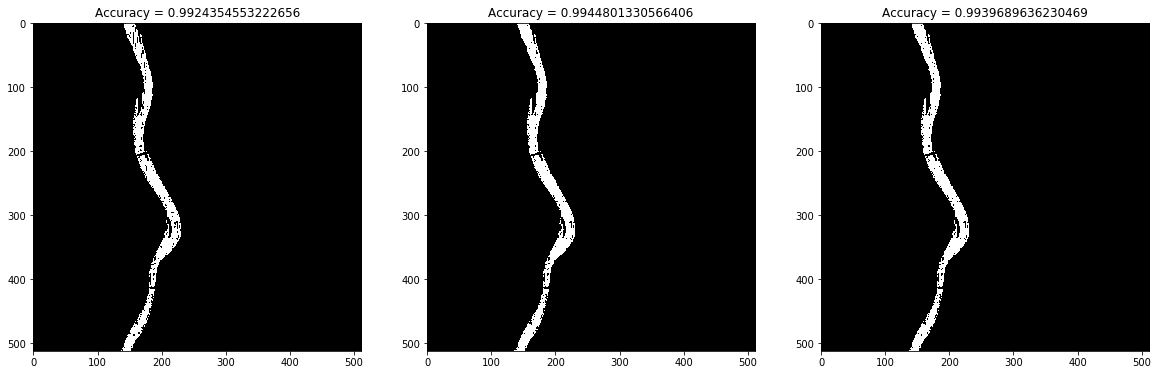

In [23]:
test_cases = [(0.3, 0.7),
              (0.7, 0.3),
              (0.5, 0.5)
             ]

results = []
for t in test_cases:
  results.append(predict(*t))


y_actual = masked_image.flatten()
# compute accuracy
acc = [accuracy_score(r.flatten(), y_actual) for r in results]
  
plt.figure(figsize=(20, 20))
for i, r in enumerate(results):
  ax = plt.subplot(f'13{i+1}')
  ax.grid(False)
  ax.imshow(r, cmap='gray')
  ax.set_title(f'Accuracy = {acc[i]}')